In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../dataset/')
sys.path.append('/home/kirill/Учеба/asbestos/src/')
from dataset import load_img
from utils import get_paths_from_dirs
import os
import cv2
from dataset import AsbestosDataSet
from albumentations import Resize,Normalize
from albumentations import functional as F
from catalyst import dl, metrics, utils;
from models import Attention_Unet, Unet
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import albumentations as A
from models.utils import TverskyLoss 

In [2]:
dataset = AsbestosDataSet('/home/kirill/Учеба/asbestos/PitStonesData/48_macro_asbest_resize/images',
                          '/home/kirill/Учеба/asbestos/PitStonesData/48_macro_asbest_resize/segmentation', 
                          [Resize(64,64)],
                          preload_data = False
)

In [3]:
dataset = AsbestosDataSet('/home/kirill/Учеба/asbestos/PitStonesData/48_test/image',
                          '/home/kirill/Учеба/asbestos/PitStonesData/48_test/segmentation', 
                          A.Compose([A.Resize(128,128)]),
                          preload_data = True
)

In [4]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
    def forward(self, inputs, targets, smooth=1e-5):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        return 1 - dice

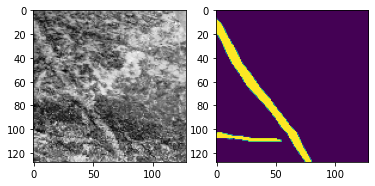

In [5]:
n = 90
img = dataset[n]['image']
mask = dataset[n]['mask']
fig, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap="Greys_r")
ax[1].imshow(mask)

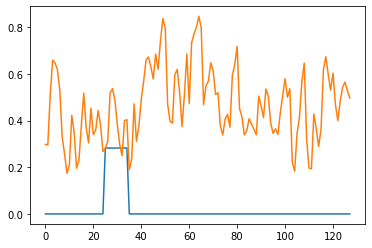

In [6]:
plt.plot(mask[62,])
plt.plot(img[62,])

In [7]:
class CustomRunner(dl.Runner):
    def predict_batch(self, batch):
        return self.model(batch['image'].to(self.device))
    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = { key: metrics.AdditiveValueMetric(compute_on_call=True)
                        for key in ["loss", "iou"]}
        
    def handle_batch(self, batch):
        image, mask, name = batch.values()
        image = image.unsqueeze(1)
        mask  = mask.unsqueeze(1)
        predict = self.model(image)#batch size
        loss = self.criterion(predict, mask)
        #Создаем обьект
        iou_metric = metrics.IOUMetric()
        iou = iou_metric.update_key_value(predict, mask)['iou']
        self.batch_metrics.update(
            {"loss": loss, "iou": iou}
        )
        for key in ["loss", "iou"]:
            self.meters[key].update( self.batch_metrics[key].item(), self.batch_size)
        iou_metric.reset()
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
    def on_loader_end(self, runner):
        for key in ["loss", "iou"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)   

In [8]:
unet = Unet(n_channels=1, n_classes = 1 )
unet = Attention_Unet(1,1)

torch.Size([4, 128, 128])


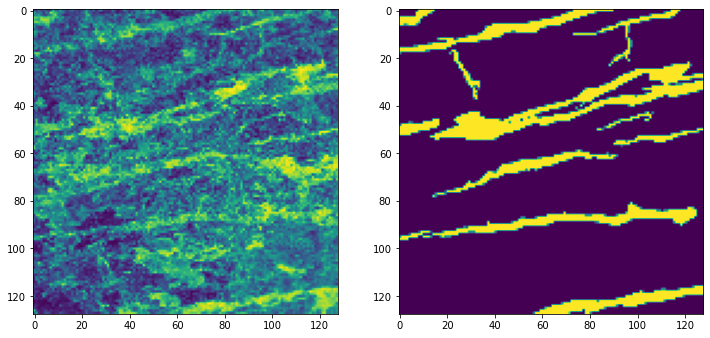

In [9]:
loader  = {"train":DataLoader(dataset, batch_size = 4)}
img = next(iter(loader['train']))['image']
img.shape

image, mask, name = next(iter(loader['train'])).values()
image = (image - image.mean())/image.std()
mask  = (mask - mask.mean())/mask.std()
print(image.shape)
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].imshow(image[0].detach().numpy())
ax[1].imshow(mask[0].detach().numpy())

In [ ]:
# criterion = DiceLoss()
criterion = TverskyLoss()
optimizer = Adam(unet.parameters())
runner = CustomRunner()
runner.train(
    model=unet,
    criterion = criterion,
    optimizer=optimizer,
    loaders=loader,
    num_epochs=200,
    logdir = 'log_tversky',
    verbose=True)

/home/kirill/anaconda3/envs/conda_3.8/lib/python3.8/site-packages/catalyst/core/runner.py:623: UserWarning: No ``ICriterionCallback/CriterionCallback`` were found while runner.criterion is not None.Do you compute the loss during ``runner.handle_batch``?
  warnings.warn(
/home/kirill/anaconda3/envs/conda_3.8/lib/python3.8/site-packages/catalyst/core/runner.py:629: UserWarning: No ``IOptimizerCallback/OptimizerCallback`` were found while runner.optimizer is not None.Do run backward pass during ``runner.handle_batch``?
  warnings.warn(



train (1/200) iou: 0.03425368799975045 | loss: 0.933934620179628
* Epoch (1/200) 



train (2/200) iou: 0.042144830289639924 | loss: 0.9194161684889544
* Epoch (2/200) 



train (3/200) iou: 0.051178873487209016 | loss: 0.9031326883717588
* Epoch (3/200) 



train (4/200) iou: 0.06222772637480184 | loss: 0.8836154598938791
* Epoch (4/200) 



train (5/200) iou: 0.07273776990018392 | loss: 0.8655845648364017
* Epoch (5/200) 



train (6/200) iou: 0.08256120117087112 | loss: 0.8491068739640084
* Epoch (6/200) 



train (7/200) iou: 0.09287201526917908 | loss: 0.8319320396373145
* Epoch (7/200) 



train (8/200) iou: 0.10002800932056023 | loss: 0.8199664128454107
* Epoch (8/200) 



train (9/200) iou: 0.10512157490378929 | loss: 0.8118139906933434
* Epoch (9/200) 



train (10/200) iou: 0.10533454457395956 | loss: 0.8117121909794054
* Epoch (10/200) 



train (11/200) iou: 0.11607274326838944 | loss: 0.794291611721641
* Epoch (11/200) 



train (12/200) iou: 0.12308531654508488 | loss: 0.783353678803695
* Epoch (12/200) 



train (13/200) iou: 0.12809030844977026 | loss: 0.7754319354107505
* Epoch (13/200) 



train (14/200) iou: 0.12930228412151334 | loss: 0.773676165781523
* Epoch (14/200) 



train (15/200) iou: 0.1413338822753806 | loss: 0.7549466773083335
* Epoch (15/200) 



train (16/200) iou: 0.14717077840315668 | loss: 0.7460198665920059
* Epoch (16/200) 



train (17/200) iou: 0.14526341588873612 | loss: 0.748807722643802
* Epoch (17/200) 



train (18/200) iou: 0.15242103871546295 | loss: 0.7377530267364102
* Epoch (18/200) 



train (19/200) iou: 0.15963916292316038 | loss: 0.7267714512975593
* Epoch (19/200) 



train (20/200) iou: 0.16517844702068127 | loss: 0.7184079935676173
* Epoch (20/200) 



train (21/200) iou: 0.1648976848313683 | loss: 0.7190914580696507
* Epoch (21/200) 



train (22/200) iou: 0.16813893192692808 | loss: 0.7140753093518708
* Epoch (22/200) 



train (23/200) iou: 0.17472762277251794 | loss: 0.7042066749773527
* Epoch (23/200) 



train (24/200) iou: 0.17889330826307598 | loss: 0.698134512022922
* Epoch (24/200) 



train (25/200) iou: 0.18392843682514992 | loss: 0.6907567118343555
* Epoch (25/200) 



train (26/200) iou: 0.18515974487129008 | loss: 0.6887210933785689
* Epoch (26/200) 



train (27/200) iou: 0.18117320914017523 | loss: 0.6946569492942407
* Epoch (27/200) 



train (28/200) iou: 0.1825910089831603 | loss: 0.6923025476305109
* Epoch (28/200) 



train (29/200) iou: 0.1912592128703469 | loss: 0.6798927288306386
* Epoch (29/200) 



train (30/200) iou: 0.19293902155600096 | loss: 0.6774486617038125
* Epoch (30/200) 



train (31/200) iou: 0.19564429474504375 | loss: 0.6736720398852698
* Epoch (31/200) 



train (32/200) iou: 0.19727912498147865 | loss: 0.6712307898621809
* Epoch (32/200) 



train (33/200) iou: 0.198777342626923 | loss: 0.6690124235655133
* Epoch (33/200) 



train (34/200) iou: 0.2018984129554347 | loss: 0.664696350850557
* Epoch (34/200) 



train (35/200) iou: 0.204552654216164 | loss: 0.6610017789037603
* Epoch (35/200) 



train (36/200) iou: 0.2049002968951276 | loss: 0.6604367607518246
* Epoch (36/200) 



train (37/200) iou: 0.19854467573918794 | loss: 0.6693483678918137
* Epoch (37/200) 



train (38/200) iou: 0.20258460452682095 | loss: 0.6636243945673892
* Epoch (38/200) 



train (39/200) iou: 0.2059230084481992 | loss: 0.6589586044612684
* Epoch (39/200) 



train (40/200) iou: 0.2104086929245999 | loss: 0.6527683923118992
* Epoch (40/200) 



train (41/200) iou: 0.21231886195509053 | loss: 0.6501943431402506
* Epoch (41/200) 



train (42/200) iou: 0.21493986123486566 | loss: 0.6465267871555529
* Epoch (42/200) 



train (43/200) iou: 0.21341824280588256 | loss: 0.648652978947288
* Epoch (43/200) 



train (44/200) iou: 0.2138171007758693 | loss: 0.6480164691021568
* Epoch (44/200) 



train (45/200) iou: 0.216079875042564 | loss: 0.6449838324597007
* Epoch (45/200) 



train (46/200) iou: 0.21996224459848907 | loss: 0.6396482128846017
* Epoch (46/200) 



train (47/200) iou: 0.2208338555536772 | loss: 0.6384570586053948
* Epoch (47/200) 



train (48/200) iou: 0.22114434461844593 | loss: 0.6380629765359979
* Epoch (48/200) 



train (49/200) iou: 0.222865743856681 | loss: 0.635753605867687
* Epoch (49/200) 



train (50/200) iou: 0.22323251272502698 | loss: 0.6352410830949483
* Epoch (50/200) 



train (51/200) iou: 0.2247053331450412 | loss: 0.6332693325845817
* Epoch (51/200) 



train (52/200) iou: 0.22204814537575368 | loss: 0.6367871748773676
* Epoch (52/200) 



train (53/200) iou: 0.22653851807117464 | loss: 0.6307841978575055
* Epoch (53/200) 



train (54/200) iou: 0.22624602129584867 | loss: 0.6311396837234496
* Epoch (54/200) 



train (55/200) iou: 0.2284370287468559 | loss: 0.6282060767474928
* Epoch (55/200) 



train (56/200) iou: 0.22626122644073085 | loss: 0.631140668768632
* Epoch (56/200) 



train (57/200) iou: 0.22783373186462805 | loss: 0.6290460868885641
* Epoch (57/200) 



train (58/200) iou: 0.22653378922688336 | loss: 0.6307987225683112
* Epoch (58/200) 



train (59/200) iou: 0.21949909266672635 | loss: 0.6403340201628835
* Epoch (59/200) 



train (60/200) iou: 0.22290550235070686 | loss: 0.6357306756471333
* Epoch (60/200) 



train (61/200) iou: 0.22872900743233535 | loss: 0.6278442276151556
* Epoch (61/200) 



train (62/200) iou: 0.23148377129906103 | loss: 0.6241740201648912
* Epoch (62/200) 



train (63/200) iou: 0.23415400354485766 | loss: 0.6206526166514346
* Epoch (63/200) 



train (64/200) iou: 0.23518227464274355 | loss: 0.6192805208657917
* Epoch (64/200) 



train (65/200) iou: 0.23682360805963215 | loss: 0.6171005562732094
* Epoch (65/200) 



train (66/200) iou: 0.23778389190372667 | loss: 0.6158574869758204
* Epoch (66/200) 



train (67/200) iou: 0.23850442955368442 | loss: 0.6149106590371383
* Epoch (67/200) 



train (68/200) iou: 0.23951315409258792 | loss: 0.6135982664007891
* Epoch (68/200) 



train (69/200) iou: 0.2392139281097211 | loss: 0.6139704001577277
* Epoch (69/200) 



train (70/200) iou: 0.23924468096933868 | loss: 0.6139514258033352
* Epoch (70/200) 



train (71/200) iou: 0.23953352978355005 | loss: 0.6135506479363692
* Epoch (71/200) 



train (72/200) iou: 0.24048913215336049 | loss: 0.6123004543153864
* Epoch (72/200) 



train (73/200) iou: 0.24104468132320203 | loss: 0.6115941411570499
* Epoch (73/200) 



train (74/200) iou: 0.24000265253217595 | loss: 0.6129411898161236
* Epoch (74/200) 



train (75/200) iou: 0.23906751243691698 | loss: 0.6141618414929039
* Epoch (75/200) 



train (76/200) iou: 0.2398485459779438 | loss: 0.6131354978210046
* Epoch (76/200) 



train (77/200) iou: 0.2405705825278634 | loss: 0.6121980328308908
* Epoch (77/200) 



train (78/200) iou: 0.24122322484066613 | loss: 0.611383268707677
* Epoch (78/200) 



train (79/200) iou: 0.24349124431610109 | loss: 0.6084016410928023
* Epoch (79/200) 



train (80/200) iou: 0.24400688692143088 | loss: 0.6077340238972714
* Epoch (80/200) 



train (81/200) iou: 0.24513919573081172 | loss: 0.606259947074087
* Epoch (81/200) 



train (82/200) iou: 0.2455729007720948 | loss: 0.6056927994677895
* Epoch (82/200) 



train (83/200) iou: 0.24565793746396117 | loss: 0.6055756117168226
* Epoch (83/200) 



train (84/200) iou: 0.2452654618965952 | loss: 0.6060670714629324
* Epoch (84/200) 



train (85/200) iou: 0.24424817405248941 | loss: 0.6073723353837667
* Epoch (85/200) 



train (86/200) iou: 0.24401800883443728 | loss: 0.6076888592619645
* Epoch (86/200) 



train (87/200) iou: 0.24420262732003867 | loss: 0.607499805249666
* Epoch (87/200) 



train (88/200) iou: 0.24524845324064556 | loss: 0.6061048375932793
* Epoch (88/200) 



train (89/200) iou: 0.245607623614763 | loss: 0.6056263271131014
* Epoch (89/200) 



train (90/200) iou: 0.24395060194166082 | loss: 0.6077984427150928
* Epoch (90/200) 



train (91/200) iou: 0.24428358078002926 | loss: 0.6073668900289034
* Epoch (91/200) 



train (92/200) iou: 0.2424736487238031 | loss: 0.6097056752757023
* Epoch (92/200) 



train (93/200) iou: 0.2453407152702934 | loss: 0.605981449077004
* Epoch (93/200) 


In [31]:
torch.save(unet.state_dict(),'attention.pt')

In [35]:
model = Attention_Unet(1,1)
state = torch.load('attention.pt')
model.load_state_dict(state)

<All keys matched successfully>

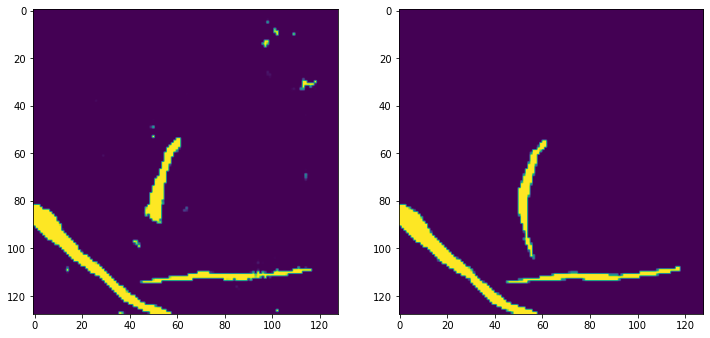

In [37]:
import torch
n = 15
img = dataset[n]['image']
mask = dataset[n]['mask']
out = model(torch.tensor(img).unsqueeze(0).unsqueeze(0))

fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].imshow(out[0,0,:].detach().numpy())
ax[1].imshow(mask)

In [25]:
test = load_img('/home/kirill/Учеба/asbestos/PitStonesData/asbestos_stone_lab_common_camera/images/asbestos/stones/lab_common_camera/IMG_2711.png',
                float)
test = cv2.resize(test, (128,128))

In [26]:
test = test.sum(axis = 2)
test = test/ test.max()

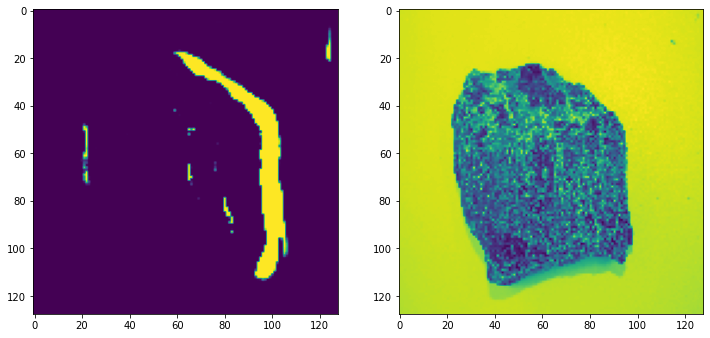

In [27]:
y_hat = unet(torch.tensor(test,dtype = torch.float).unsqueeze(0).unsqueeze(0))

fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].imshow(y_hat[0,0,:].detach().numpy())
ax[1].imshow(test)